# NNCL ASSIGNMENT 3

## Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

C:\Users\oyjuf\AppData\Local\Temp\ipykernel_6992\2080034654.py:2: DeprecationWarning: 
Pyarrow will become a required dependency of pandas in the next major release of pandas (pandas 3.0),
(to allow more performant data types, such as the Arrow string type, and better interoperability with other libraries)
but was not found to be installed on your system.
If this would cause problems for you,
please provide us feedback at https://github.com/pandas-dev/pandas/issues/54466
        
  import pandas as pd


## Neural Network

In [2]:
class Network:
    def __init__(self, P, Q, N, K, learning_rate):
        self.P = P                      # Number of input samples
        self.Q = Q                      # Number of test samples
        self.N = N                      # Number of neurons in the input layer
        self.K = K                      # Number of neurons in the hidden layer
        self.eta = learning_rate        # Learning rate for the neural network
        self.W = self.initWeights()     # Weights from input layer to hidden layer
        self.V = np.ones((1, self.K))   # Weights from hidden layer to output layer, initialized to 1

    def initWeights(self):
        """
        This function initializes the weights of the neural network.	
        """
        # Generate random weights for each neuron in the hidden layer
        weights = np.random.randn(self.N, self.K)

        # Calculate the squared norm (length) of each weight vector
        norms_squared = np.linalg.norm(weights, axis=1, keepdims=True) ** 2

        # Normalize each weight vector to have a length of 1
        normalized_weights = weights / norms_squared

        return normalized_weights

    def forwardPass(self, x):
        """
        This function performs the forward pass of a neural network with a single hidden layer.
        It uses the tanh activation function for the hidden layer neurons.
        """
        # Calculate the dot product of the input vector 'x' and the transpose of the weight matrix 'W' of the first layer.
        dot_product = np.dot(self.W.T, x)

        # Apply the hyperbolic tangent function element-wise to the result of the dot product.
        tanh_result = np.tanh(dot_product)

        # Calculate the output of the network ('sigma') by multiplying the output weights 'V' with the tanh_result and summing the result.
        sigma = np.sum(self.V * tanh_result)

        # Return the output of the network for the given input 'x'.
        return sigma

    def stochasticGradientDescent(self, sigma, xi, tau):
        """
        This function performs the stochastic gradient descent optimization algorithm.
        It updates the weights of the network based on the error of the network's output.
        """
        # Iterate over each neuron in the hidden layer
        for i in range(self.K):
            # Compute the gradient of the error with respect to the weights
            gradient = (sigma - tau) * (1 - np.tanh(np.dot(self.W[:, i], xi)) ** 2)
            
            # Update the weights by subtracting the product of the learning rate, the gradient, and the input
            self.W[:, i] -= self.eta * gradient * xi

    def calculateError(self, sigma, tau):
        """
        This function calculates the error of the neural network's output.
        The error is defined as the half of the squared difference between the network's output (sigma) and the target value (tau).
        """
        # Compute the error
        return ((sigma - tau) ** 2) / 2

    def train(self, t_max, train_set, test_set):
        """
        Train the network using stochastic gradient descent.
        """
        # Initialize lists to store training and testing errors
        train_err = []
        test_err = []

        # Run the training for t_max epochs
        for epoch in range(t_max):
            # Initialize error trackers for the current epoch
            epoch_error = 0
            epoch_error_test = 0

            # For each training sample in a random order
            for index in np.random.permutation(self.P):
                xi, tau = train_set[index]  # Get input and target output
                sigma = self.forwardPass(xi)  # Perform forward pass
                epoch_error += self.calculateError(sigma, tau)  # Calculate and accumulate error
                self.stochasticGradientDescent(sigma, xi, tau)  # Update weights using SGD

            # Calculate average training error for the epoch
            epoch_error /= self.P

            # For each testing sample in a random order
            for index in np.random.permutation(self.Q):
                xi, tau = test_set[index]  # Get input and target output
                sigma = self.forwardPass(xi)  # Perform forward pass
                epoch_error_test += self.calculateError(sigma, tau)  # Calculate and accumulate error

            # Calculate average testing error for the epoch
            epoch_error_test /= self.Q

            # Store the average errors for this epoch
            train_err.append(epoch_error)
            test_err.append(epoch_error_test)

            # Print the average errors for this epoch
            print(f"Epoch: {epoch}, Error: {epoch_error.item()}, Test Error: {epoch_error_test.item()}")

        # Return the list of average training and testing errors for each epoch
        return train_err, test_err

## Run Networks

In [3]:
# Load input data from CSV file
xi = pd.read_csv("data/xi.csv", delimiter=",", header=None)

# Load target output data from CSV file
tau = pd.read_csv("data/tau.csv", delimiter=",", header=None)

# Combine input and target output data into a dataset of (input, target) pairs
dataset = [(xi.iloc[:, i], tau.iloc[:, i][0]) for i in range(5000)]

# Define network parameters
P = 600  # Number of training samples
Q = 200  # Number of testing samples
N = 50   # Input dimensionality
K = 2    # Number of neurons in the hidden layer

# Split dataset into training and testing sets
train_set = dataset[:P]
test_set = dataset[P:P+Q]

# Initialize network with specified parameters and learning rate
network = Network(P=P, Q=Q, N=N, K=K, learning_rate=0.05)

# Train the network and retrieve training and testing errors
train_err, test_err = network.train(t_max=100, train_set=train_set, test_set=test_set)

Epoch: 0, Error: 0.8577485358906997, Test Error: 0.6090503293676887
Epoch: 1, Error: 0.47205419469990745, Test Error: 0.3764499491878967
Epoch: 2, Error: 0.25310155589684, Test Error: 0.18710804040384435
Epoch: 3, Error: 0.15035820966158273, Test Error: 0.18357722195085402
Epoch: 4, Error: 0.12023626300447901, Test Error: 0.14852876845416665
Epoch: 5, Error: 0.11001425074793979, Test Error: 0.14019920221044674
Epoch: 6, Error: 0.09940835410951677, Test Error: 0.14986005299477723
Epoch: 7, Error: 0.09298632708742034, Test Error: 0.13707889399972348
Epoch: 8, Error: 0.08942673425009007, Test Error: 0.14211109495399832
Epoch: 9, Error: 0.08623983381650153, Test Error: 0.1447109966698978
Epoch: 10, Error: 0.08403793859086973, Test Error: 0.1347807798180851
Epoch: 11, Error: 0.08214614638935591, Test Error: 0.1370424323303691
Epoch: 12, Error: 0.08239956614275838, Test Error: 0.12250598996294007
Epoch: 13, Error: 0.08195698413783478, Test Error: 0.12975130794900316
Epoch: 14, Error: 0.08177

## Plot the Results

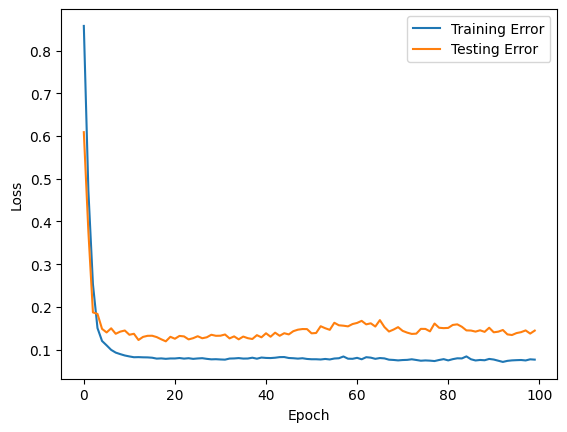

In [4]:
# Plot the training and testing errors over epochs
plt.plot(train_err, label="Training Error")
plt.plot(test_err, label="Testing Error")

# Add a legend to the plot
plt.legend()

# Add labels to the x and y axes
plt.xlabel('Epoch')
plt.ylabel('Loss')

# Display the plot
plt.show()